<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/torchvision_utils_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# import torchvision.transforms.functional as F

# from torchvision.utils import make_grid
# from torchvision.io import read_image
# from pathlib import Path

# cat1 = read_image('cat1.png')
# cat2 = read_image('cat2.png')
# cats = [cat1, cat2]

# grid = make_grid(cats)
# show(grid)

In [3]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# import torchvision.transforms.functional as F

# from torchvision.utils import make_grid
# from torchvision.io import read_image

In [5]:
from torchvision.io import read_image

cat1 = read_image('cat1.png')
cat2 = read_image('cat2.png')
cats = [cat1, cat2]

## make_grid

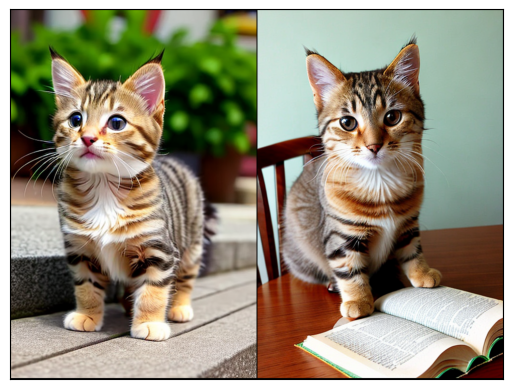

In [6]:
from torchvision.utils import make_grid

grid = make_grid(cats)
show(grid)

# img = F.to_pil_image(grid)
# plt.imshow(img)

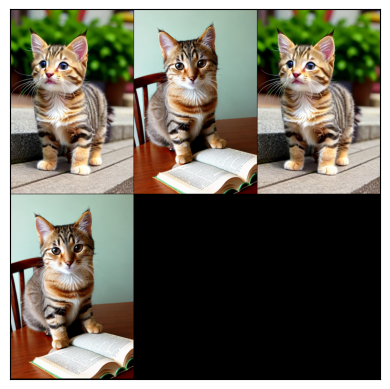

In [7]:
cats = [cat1, cat2, cat1, cat2]

grid = make_grid(cats, nrow=3)

show(grid)

# BBOX

In [8]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype

batch_int = torch.stack([cat1, cat2])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

outputs = model(batch)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [9]:
outputs[0]

{'boxes': tensor([[ 49.4662,  64.3665, 425.9760, 701.5709],
         [  0.0000, 301.2425, 512.0000, 726.1497],
         [298.9560,  18.5366, 509.6454, 422.4392],
         [371.1083, 192.5258, 502.9293, 400.5536],
         [  0.0000, 564.7842, 509.1015, 764.2759],
         [ 53.3866,  28.6720, 457.0863, 620.9099],
         [418.0938, 402.1983, 512.0000, 493.2810],
         [  0.0000, 275.1741, 478.8131, 723.5930],
         [403.0338, 406.7412, 512.0000, 551.4507],
         [395.6396, 266.7185, 485.6213, 402.8719],
         [ 11.5985,  83.1435, 336.1311, 460.2845]], grad_fn=<StackBackward0>),
 'labels': tensor([17, 15, 64, 64, 15, 64, 67, 62, 15, 86, 17]),
 'scores': tensor([0.9889, 0.5225, 0.4071, 0.3121, 0.1079, 0.0920, 0.0879, 0.0828, 0.0782,
         0.0743, 0.0509], grad_fn=<IndexBackward0>)}

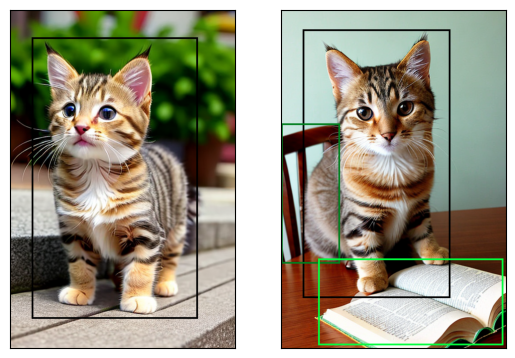

In [10]:
from torchvision.utils import draw_bounding_boxes

score_threshold = 0.9
boxes = [
    draw_bounding_boxes(img, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img, output in zip(batch_int, outputs)
]

show(boxes)

## Segmentation

In [11]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()

normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']

# print(output.shape, output.min().item(), output.max().item())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


In [12]:
output[0].shape

torch.Size([21, 768, 512])

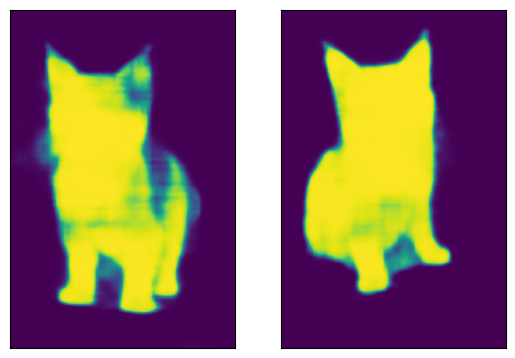

In [13]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
normalized_masks = torch.nn.functional.softmax(output, dim=1)

cat = [
    normalized_masks[img_idx, sem_class_to_idx['cat']]
    for img_idx in range(batch.shape[0])
]

show(cat)

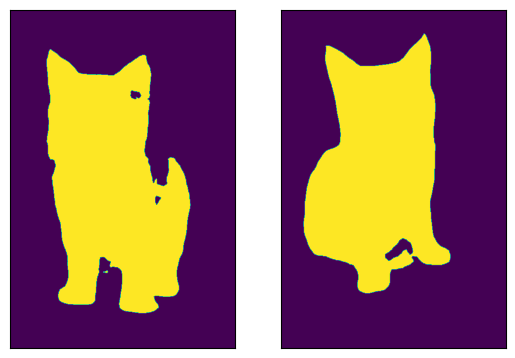

In [14]:
class_dim = 1
bool_cat = (normalized_masks.argmax(class_dim) == sem_class_to_idx['cat'])
show([m.float() for m in bool_cat])

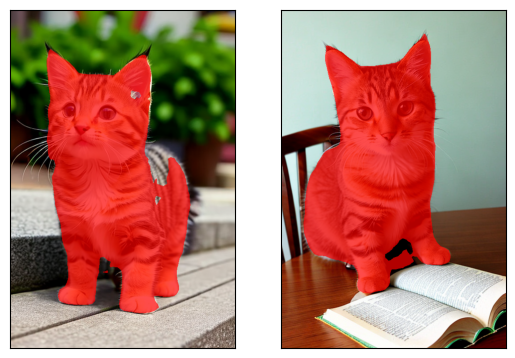

In [15]:
from torchvision.utils import draw_segmentation_masks

cats_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7, colors="red")
    for img, mask in zip(batch_int, bool_cat)
]
show(cats_masks)